<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1 Mount to Google Drive

The complete training is done on Google Colab. The following code mounts the Google Drive to the Colab environment.

In [1]:
# mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2 Import relevant libraries, define relevant paths, and model hyperparameters

In [2]:
# for opening installed packages (installed in virtual environment of Google Colab)
import sys
sys.path.append('/content/drive/MyDrive/colab_env/lib/python3.10/site-packages')
# for importing modules defined in other jupyter notebooks
import import_ipynb

In [3]:
# import relevant libraries

import os # for file handling
import glob # for file handling
import random # generate random numbers and seed setting
from tqdm import tqdm # for counter

import numpy as np # for data manipulation
import matplotlib.pyplot as plt # for plotting

from PIL import Image # read and save images
from patchify import patchify, unpatchify # for getting patches and 'unpatchifying'

import torch # for PyTorch framework
from torch.utils.data import Dataset, DataLoader # for creating custom dataset and DataLoader
import torchvision.transforms.functional as TF # for tensor transformations and normalization
import albumentations as A # for data augmentation
from torch.optim import Adam # for Adam optimizer
from torch import nn # for defining layers of unet model and resizing
import monai # for medical image segmentation loss function
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/02_unet'
from unet_dataset import UNETDataset # for custom dataset class
from unet_model import UNET # for U-Net architecture

from sklearn.metrics import accuracy_score, recall_score, precision_score # for evaluation
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation'
from evaluation_utils import dice_score, iou_score, calculate_metrics, sigmoid # for evaluation
from statistics import mean # calculate mean of metrics

/content/drive/MyDrive/cbs/master_thesis/master-thesis/02_unet
importing Jupyter notebook from unet_dataset.ipynb
importing Jupyter notebook from unet_model.ipynb
/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation
importing Jupyter notebook from evaluation_utils.ipynb


In [4]:
# define dataset path
dataset_path = '/content/drive/MyDrive/cbs/master_thesis/dataset_gray'

# define model path
model_path = '/content/drive/MyDrive/cbs/master_thesis/models'

In [5]:
# define hyperparameters to tune
batch_size = 16
number_epochs = 10
learning_rate = 0.0001

# define model name
model_name = 'unet_model_1'

### 3 Load images and masks, extract patches, and create DataLoader instance

The images and masks are coming in size of 1024x1024 and are opened using the library PIL. Images and masks are loaded for training and validation. For U-Net the images and masks are coming in a too big format. Therefore, non-overlapping image and mask patches of size 256x256 are extracted and used for training.

#### 3.1 Patch extraction function

In [6]:
def extract_patches(image_files_name:list[str], mask_files_name:list[str], patch_size:int=256):
    '''
    Opens images and masks from the given paths and extracts patches of the given size (default: 256x256).

    Args:
        image_files_name (list[str]): Paths to the images.
        mask_files_name (list[str]): Paths to the masks.
        patch_size (int): Size of the quadratic patches.

    Returns:
        images_patches (list): List of image patches.
        masks_patches (list): List of mask patches.
    '''

    # create empty lists to store patches
    images_patches = []
    masks_patches = []

    # for tqdm progress bar
    total_items = len(image_files_name)

    for image_path, mask_path in tqdm(zip(image_files_name, mask_files_name), total=total_items):
        # load images and masks
        image = np.array(Image.open(image_path).convert('L'))  # grayscale
        mask = np.array(Image.open(mask_path).convert('1'))  # binary

        # extract patches of images and masks
        image_patches = patchify(image, (patch_size, patch_size), step=patch_size)
        mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)

        # flatten patches arrays to list and add to the respective lists
        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[1]):
                images_patches.append(image_patches[i,j,:,:])
                masks_patches.append(mask_patches[i,j,:,:])

    return images_patches, masks_patches

#### 3.2 Load training images and masks

In [7]:
# training
# get file names of images
images_files_train = glob.glob(os.path.join(dataset_path, 'training', 'images', '*.jpg'))
images_files_train.sort()

# get file names of masks
masks_files_train = glob.glob(os.path.join(dataset_path, 'training', 'masks', '*.jpg'))
masks_files_train.sort()

In [8]:
# extract patches
images_train, masks_train = extract_patches(images_files_train, masks_files_train, patch_size=256)

# remove empty images and masks based on the mask
images_train = [image for image, mask in zip(images_train, masks_train) if np.sum(mask) > 0]
masks_train = [mask for mask in masks_train if np.sum(mask) > 0]

100%|██████████| 625/625 [04:35<00:00,  2.27it/s]


#### 3.3 Load validation images and masks

In [9]:
# validation
# get file names of images
images_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'images', '*.jpg'))
images_files_val.sort()

# get file names of masks
masks_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'masks', '*.jpg'))
masks_files_val.sort()

In [10]:
# extract patches
images_val, masks_val = extract_patches(images_files_val, masks_files_val, patch_size=256)

# remove empty images and masks based on the mask
images_val = [image for image, mask in zip(images_val, masks_val) if np.sum(mask) > 0]
masks_val = [mask for mask in masks_val if np.sum(mask) > 0]

100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


#### 3.4 Create DataLoader instance

This part defines how images and masks are loaded during training and which real-time data augmentation techniques are used. The custom dataset class UNETDataset is defined in the unet_dataset.ipynb file.

In [11]:
# define which transformation is applied to the training images and masks
def custom_transformation(image, mask):
    '''
    Apply custom transformations to the image and mask.
    '''

    transform = A.Compose([
        # horizontal flipping
        A.HorizontalFlip(p=0.5),

        # vertical flipping
        A.VerticalFlip(p=0.5),
    ])

    # apply transformations to both image and mask
    augmented = transform(image=image, mask=mask)

    # return augmented image and mask
    return augmented['image'], augmented['mask']

In [12]:
# create training DataLoader instance
train_dataset = UNETDataset(images=images_train, masks=masks_train, transforms=custom_transformation)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, worker_init_fn=np.random.seed(42))

# create validation DataLoader instance
val_dataset = UNETDataset(images=images_val, masks=masks_val, transforms=None)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [13]:
# check dimensions of DataLoader
batch = next(iter(train_dataloader))
images, masks = batch
print('Images shape:', images.shape)
print('Masks shape:', masks.shape)

Images shape: torch.Size([16, 1, 256, 256])
Masks shape: torch.Size([16, 256, 256])


### 4 Modelling and architecture

#### 4.2 Load model and define training parameters

The model architecture is defined in the unet_model.ipynb file.

In [14]:
# load U-Net model
model = UNET(in_channels=1, out_channels=1)

In [15]:
# set optimizer
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
# set loss function
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, reduction='mean')

In [16]:
# define training loop
num_epochs = number_epochs

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# track mean train and validation losses
mean_train_losses, mean_val_losses = [], []

# create artificial best validation loss for the start
best_val_loss = 100.0
best_val_epoch = 0

# define patience for early stopping
patience = 5
patience_counter = 0

#### 4.3 Train U-Net model

In [17]:
# set seed for reproducibility
torch.manual_seed(42) # for PyTorch
torch.backends.cudnn.deterministic = True # for PyTorch
torch.backends.cudnn.benchmark = False # for PyTorch
torch.cuda.manual_seed_all(42) # for GPU
np.random.seed(42) # for numpy
random.seed(42) # for any other operation

# train U-Net model
model.train()
for epoch in range(num_epochs):
    # training stage
    # list to record training losses
    train_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        images, masks = batch
        # use GPU if available
        images = images.to(device)
        masks = masks.float().to(device)
        # calculate loss
        outputs = model(images)
        loss = seg_loss(outputs, masks.unsqueeze(1))

        # backward pass
        # compute gradients of parameters with regards to the loss
        optimizer.zero_grad()
        loss.backward()
        # optimize weights
        optimizer.step()

        # append loss
        train_losses.append(loss.item())

    # validation stage
    # list to record validation losses and Dice scores
    val_losses = []
    # do not calculate gradients during validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            # forward pass
            images, masks = val_batch
            # use GPU if available
            images = images.to(device)
            masks = masks.float().to(device)

            # calculate validation loss
            outputs = model(images)
            val_loss = seg_loss(outputs, masks.unsqueeze(1))
            val_losses.append(val_loss.item())

        # save the model when validation loss improves
        # track current validation loss
        current_val_loss = mean(val_losses)
        if current_val_loss < best_val_loss:
            torch.save(model.state_dict(), os.path.join(model_path,  f'{model_name}.pth'))
            print(f'Model saved! Improvement in validation loss: {best_val_loss} to {current_val_loss}')
            best_val_loss = current_val_loss
            # save best validation epoch
            best_val_epoch = epoch+1
            # set patience counter back to 0
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Model not improved! Patience: {patience_counter}/{patience}')
            # trigger early stopping if patience is reached
            if patience_counter >= patience:
              print(f'Stopping early at epoch {epoch+1}. Best validation loss: {best_val_loss} at epoch {best_val_epoch}')
              break


    # print results of epoch
    print(f'Epoch: {epoch+1}')
    print(f'Mean training loss: {mean(train_losses)}')
    print(f'Mean validation loss: {mean(val_losses)}')

    # append mean training and validation losses
    mean_train_losses.append(mean(train_losses))
    mean_val_losses.append(mean(val_losses))

100%|██████████| 78/78 [00:22<00:00,  3.45it/s]


Model saved! Improvement in validation loss: 100.0 to 0.5732479821412991
Epoch: 1
Mean training loss: 0.6968044255324115
Mean validation loss: 0.5732479821412991


100%|██████████| 78/78 [00:22<00:00,  3.45it/s]


Model saved! Improvement in validation loss: 0.5732479821412991 to 0.4012619673441618
Epoch: 2
Mean training loss: 0.47595668136115243
Mean validation loss: 0.4012619673441618


100%|██████████| 78/78 [00:22<00:00,  3.47it/s]


Model saved! Improvement in validation loss: 0.4012619673441618 to 0.3320626761668768
Epoch: 3
Mean training loss: 0.35628124554057594
Mean validation loss: 0.3320626761668768


100%|██████████| 78/78 [00:22<00:00,  3.48it/s]


Model saved! Improvement in validation loss: 0.3320626761668768 to 0.30177163294492626
Epoch: 4
Mean training loss: 0.3128270322630643
Mean validation loss: 0.30177163294492626


100%|██████████| 78/78 [00:22<00:00,  3.48it/s]


Model not improved! Patience: 1/5
Epoch: 5
Mean training loss: 0.2950437616592818
Mean validation loss: 0.3036066733109645


100%|██████████| 78/78 [00:22<00:00,  3.47it/s]


Model saved! Improvement in validation loss: 0.30177163294492626 to 0.2777376006811093
Epoch: 6
Mean training loss: 0.28263853459208726
Mean validation loss: 0.2777376006811093


100%|██████████| 78/78 [00:22<00:00,  3.48it/s]


Model not improved! Patience: 1/5
Epoch: 7
Mean training loss: 0.27539134188480313
Mean validation loss: 0.2799010721918864


100%|██████████| 78/78 [00:22<00:00,  3.47it/s]


Model saved! Improvement in validation loss: 0.2777376006811093 to 0.2712272122884408
Epoch: 8
Mean training loss: 0.2736029957460054
Mean validation loss: 0.2712272122884408


100%|██████████| 78/78 [00:22<00:00,  3.47it/s]


Model not improved! Patience: 1/5
Epoch: 9
Mean training loss: 0.2696919286701457
Mean validation loss: 0.29265255710253346


100%|██████████| 78/78 [00:22<00:00,  3.48it/s]

Model not improved! Patience: 2/5
Epoch: 10
Mean training loss: 0.26578140773861353
Mean validation loss: 0.2772961062116501


#### 4.4 Plot training and validation losses

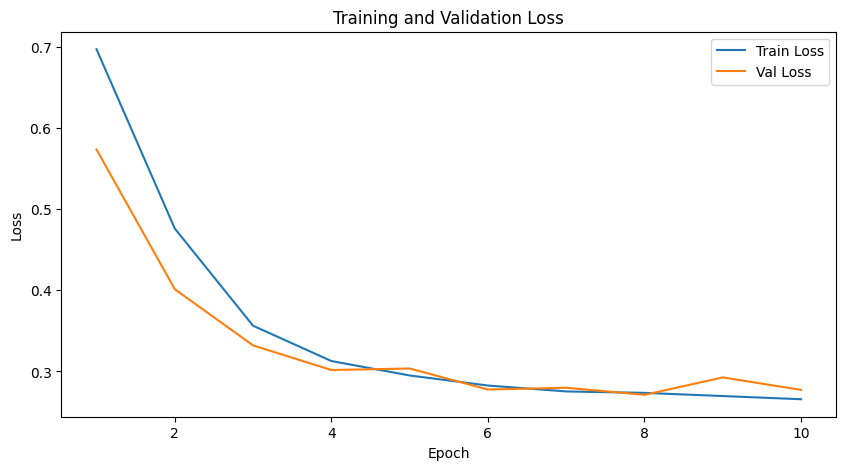

In [18]:
# plot results of training
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mean_train_losses)+1), mean_train_losses, label='Train Loss')
plt.plot(range(1, len(mean_val_losses)+1), mean_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 5 Evaluate on the validation set

#### 5.1 Load the trained model

In [19]:
# load trained U-Net model
unet_model = UNET(in_channels=1, out_channels=1)

# load trained weights
unet_model.load_state_dict(torch.load(os.path.join(model_path, f'{model_name}.pth')))

<All keys matched successfully>

In [20]:
# set the device to cuda if available, otherwise use cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model.to(device)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

#### 5.2 Visual inspection of predicted masks

In [21]:
# load validation images and masks
# get file names of validation images
images_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'images', '*.jpg'))
images_files_val.sort()

# get file names of validation masks
masks_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'masks', '*.jpg'))
masks_files_val.sort()

# select random image number
image_number = 1

# load image and mask
image = np.array(Image.open(images_files_val[image_number]).convert('L'))
y_true = np.array(Image.open(masks_files_val[image_number]).convert('1'))

# extract patches of the image
patches = patchify(image, (256, 256), step=256)

# set U-Net model to evaluation mode
unet_model.eval()
# empty list to store patches
predicted_patches = []

# go through all patches and predict mask
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i,j,:,:]
        # transform to tensors and normalize the images
        patch = TF.to_tensor(patch)
        patch = TF.normalize(patch, [0.0], [1.0])
        patch = patch.unsqueeze(0).to(device)
        with torch.no_grad():
            # predict using model
            prediction = unet_model(patch.to(device))
            # remove batch dimension
            prediction = prediction.squeeze().cpu().numpy()
        predicted_patches.append(prediction)

# reshape predicted patches to match the shape of patchify output for unpatchify
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

# get original mask by 'unpatchifying'
y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
# apply sigmoid to get probabilities
y_prob = sigmoid(y_prob)
# convert to binary using threshold
y_pred = (y_prob > 0.5).astype(np.float32)

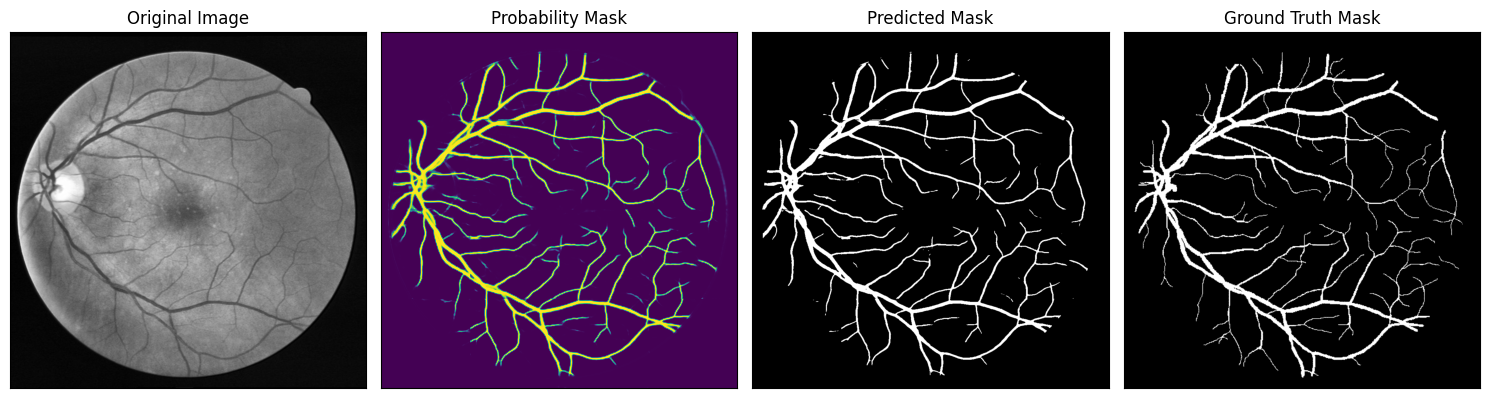

In [22]:
# visualize the results
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# plot original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

# plot probability mask
axes[1].imshow(y_prob)
axes[1].set_title('Probability Mask')

# plot predicted mask
axes[2].imshow(y_pred, cmap='gray')
axes[2].set_title('Predicted Mask')

# plot ground truth mask
axes[3].imshow(y_true, cmap='gray')
axes[3].set_title('Ground Truth Mask')

# hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# adjust spacing between subplots
plt.tight_layout()

# show the images and masks
plt.show()

#### 5.3 Evaluate with metrics

In [23]:
# empty dictionaries to store metrics
all_metrics = {}

# define thresholds to optimize
thresholds = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]

# load validation images and masks
# get file names of validation images
images_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'images', '*.jpg'))
images_files_val.sort()

# get file names of validation masks
masks_files_val = glob.glob(os.path.join(dataset_path, 'validation', 'masks', '*.jpg'))
masks_files_val.sort()

# set model to evaluation mode
unet_model.eval()

# for tqdm progress bar
total_items = len(images_files_val)

for image_path, mask_path in tqdm(zip(images_files_val, masks_files_val), total=total_items):
    # load image and mask
    image = np.array(Image.open(image_path).convert('L'))
    y_true = np.array(Image.open(mask_path).convert('1'))

    # extract patches of the image
    patches = patchify(image, (256, 256), step=256)

    # empty list to store patches
    predicted_patches = []

    # go through all patches and predict mask
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:]
            # transform to tensors and normalize the images
            patch = TF.to_tensor(patch)
            patch = TF.normalize(patch, [0.0], [1.0])
            patch = patch.unsqueeze(0).to(device)
            with torch.no_grad():
                # predict using model
                prediction = unet_model(patch.to(device))
                # remove batch dimension
                prediction = prediction.squeeze().cpu().numpy()
            predicted_patches.append(prediction)

    # reshape predicted patches to match the shape of patchify output for unpatchify
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

    # get original mask by 'unpatchifying'
    y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
    # apply sigmoid to get probabilities
    y_prob = sigmoid(y_prob)

    # calculate metrics for defined thresholds
    metrics = calculate_metrics(y_true, y_prob, thresholds)

    # aggregate metrics for all images
    for threshold, metric_values in metrics.items():
        if threshold not in all_metrics:
            all_metrics[threshold] = []
        all_metrics[threshold].append(metric_values)

# print mean metrics
for threshold, metric_values in all_metrics.items():
    print(f'\nResults for {threshold}:')
    for metric_name in metric_values[0].keys():
        mean_metric = np.mean([metric[metric_name] for metric in metric_values])
        print(f'Mean {metric_name.capitalize()}: {round(mean_metric, 4)}')

100%|██████████| 78/78 [09:49<00:00,  7.55s/it]


Results for threshold_0.35:
Mean Accuracy: 0.976
Mean Precision: 0.8361
Mean Recall: 0.8598
Mean Dice: 0.844
Mean Iou: 0.7358

Results for threshold_0.4:
Mean Accuracy: 0.9764
Mean Precision: 0.8445
Mean Recall: 0.8534
Mean Dice: 0.8452
Mean Iou: 0.7375

Results for threshold_0.45:
Mean Accuracy: 0.9768
Mean Precision: 0.8524
Mean Recall: 0.847
Mean Dice: 0.8459
Mean Iou: 0.7386

Results for threshold_0.5:
Mean Accuracy: 0.9771
Mean Precision: 0.86
Mean Recall: 0.8404
Mean Dice: 0.8463
Mean Iou: 0.7392

Results for threshold_0.55:
Mean Accuracy: 0.9773
Mean Precision: 0.8674
Mean Recall: 0.8334
Mean Dice: 0.8463
Mean Iou: 0.7391

Results for threshold_0.6:
Mean Accuracy: 0.9774
Mean Precision: 0.8748
Mean Recall: 0.8258
Mean Dice: 0.8458
Mean Iou: 0.7383

Results for threshold_0.65:
Mean Accuracy: 0.9775
Mean Precision: 0.8823
Mean Recall: 0.8174
Mean Dice: 0.8448
Mean Iou: 0.7368
